In [3]:
import numpy as np
import glob, os, json

# score_path = "/data/mint/TPAMI_evaluations/MP/score/tuning_solver/"
# score_path = "/data/mint/TPAMI_evaluations/MP/score/notuning_solver/multipie/mp_test"
score_path = "/data/mint/TPAMI_evaluations/MP/score/notuning_solver/multipie/mp_test2"

score_dict = {
    "dpmsolver" : {
        "steps" : {}
    },
    "dpmsolver++" : {
        "steps" : {}
    },
    "unipc" : {
        "steps" : {}
    }
}

m_sel = 'multistep'
o_sel = 2
metrices = ['mse', 'lpips', 'dssim']
for s in glob.glob(score_path + '/*.json'):
    name = os.path.basename(s).split('.')[0].split('eval_score_')[1]
    solver_name, method, steps, order, _ = name.split('_')
    
    if method == m_sel and int(order) == o_sel:
        with open(s, 'r') as f:
            data = json.load(f)
            # Data example : 0.017334407195448875 +- 0.023438921198248863
            score_dict[solver_name]['steps'][steps] = {}
            for m_type in metrices:
                mean_error, sd_error = data['eval_score'][m_type].split('+-')
                mean_error = float(mean_error)
                sd_error = float(sd_error)
                score_dict[solver_name]['steps'][steps][f'mean_{m_type}'] = mean_error
                score_dict[solver_name]['steps'][steps][f'sd_{m_type}'] = sd_error
            # Sorted by steps
            score_dict[solver_name]['steps'] = dict(sorted(score_dict[solver_name]['steps'].items(), key=lambda item: int(item[0])))

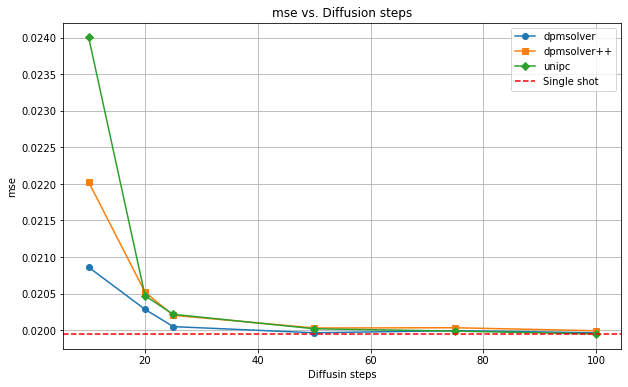

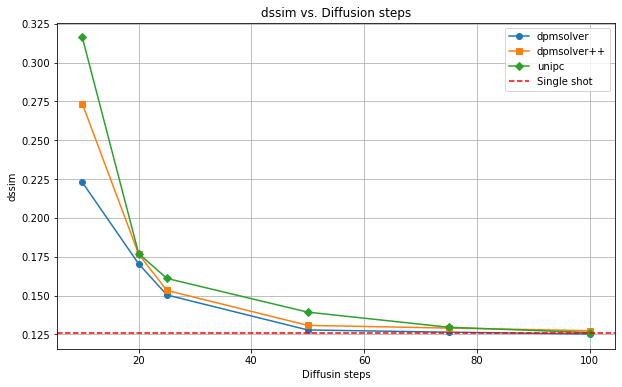

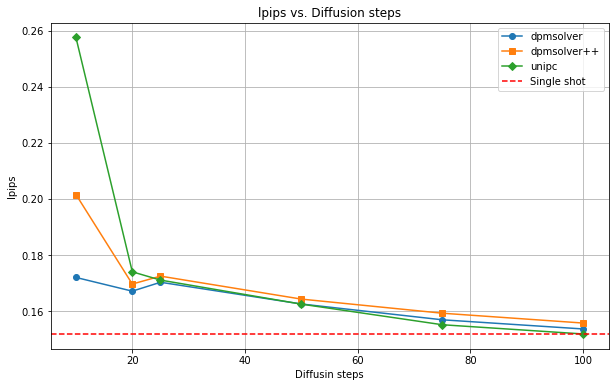

In [4]:
import matplotlib.pyplot as plt
# print(score_dict)

def plot(score_dict, metric, solver_name, marker=['o', 's', 'D']):
    # Your data
    # Create the plot
    plt.figure(figsize=(10, 6))
    for i, sn in enumerate(solver_name):
        x = []
        y = []
        running_time = []
        for steps, error in score_dict[sn]['steps'].items():
            x.append(int(steps))
            y.append(float(error[f'mean_{metric}']))

        plt.plot(x, y, marker=marker[i], linestyle='-', label=sn)

    # Add titles and labels
    plt.title(f'{metric} vs. Diffusion steps')
    plt.xlabel('Diffusin steps')
    plt.ylabel(f'{metric}')
    
    # Adding single shot
    plt.axhline(y=np.min(y), color='r', linestyle='--', label='Single shot')   
    
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

plot(score_dict, 'mse', ['dpmsolver', 'dpmsolver++', 'unipc'])
plot(score_dict, 'dssim', ['dpmsolver', 'dpmsolver++', 'unipc'])
plot(score_dict, 'lpips', ['dpmsolver', 'dpmsolver++', 'unipc'])
